#### From : https://github.com/TuSimple/tusimple-benchmark/blob/master/example/lane_demo.ipynb
Create road lane semantic segmentation dataset from tuSimple dataset

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import glob
import os
import random

In [3]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [4]:
import torch
from torch.utils import data

In [5]:
from skimage.transform import AffineTransform, warp
from skimage import img_as_float64, img_as_ubyte

### tuSimple dataset

In [6]:
train_path = '/data/tuSimple/train_set/'
test_path = '/data/tuSimple/test_set/'
json_0313_path = '/data/tuSimple/train_set/label_data_0313.json'
json_0531_path = '/data/tuSimple/train_set/label_data_0531.json'
json_0601_path = '/data/tuSimple/train_set/label_data_0601.json'

In [7]:
json_lists = glob.glob(os.path.join(train_path, "*.json"))

In [8]:
train_json = []
for json_list in json_lists:
    train_json += [json.loads(line) for line in open(json_list)]

In [9]:
lanes = [lane['lanes'] for lane in train_json]
y_samples = [y_sample['h_samples'] for y_sample in train_json]
raw_files = [raw_file['raw_file'] for raw_file in train_json]

ind = np.random.randint(0, len(lanes)-1)
lane_pts = [[(x,y) for (x,y) in zip(lane, y_samples[0]) if x >= 0] for lane in lanes[ind]]
n_lanes = len(lane_pts)

In [10]:
img = plt.imread(os.path.join(train_path, raw_files[ind]))
height, width, _ = img.shape
label_img = np.zeros((height, width), dtype=np.uint8)
ins_img = np.zeros((0, height, width), dtype=np.uint8)


In [11]:
for i, lane_pt in enumerate(lane_pts):
    cv2.polylines(label_img, np.int32([lane_pt]), isClosed=False, color=(255), thickness=10)
    gt = np.zeros((height, width), dtype=np.uint8)
    gt = cv2.polylines(gt, np.int32([lane_pt]), isClosed=False, color=(1), thickness=10)
    ins_img = np.concatenate([ins_img, gt[np.newaxis]])


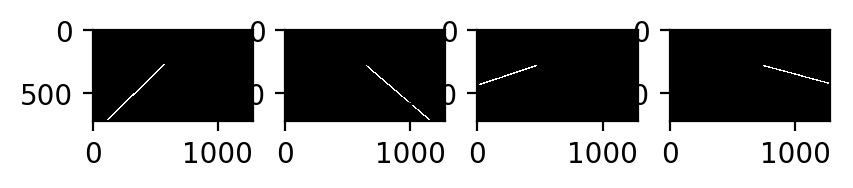

In [12]:
plt.figure(dpi=200)
plt.gray()
plt.subplot(151); plt.imshow(ins_img[0])
plt.subplot(152); plt.imshow(ins_img[1])
plt.subplot(153); plt.imshow(ins_img[2])
plt.subplot(154); plt.imshow(ins_img[3])
# plt.subplot(155); plt.imshow(ins_mask[4])

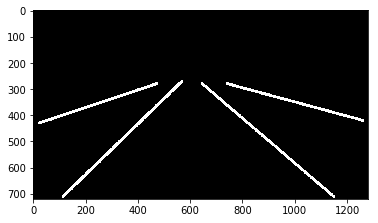

In [13]:
plt.imshow(label_img)

In [14]:
def gen_mask(ins_img):
    mask = []
    for i, mask_i in enumerate(ins_img):
        binarized = mask_i * (i + 1)
        mask.append(binarized)
    mask = np.sum(np.stack(mask, axis=0), axis=0).astype(np.uint8)
    return mask

In [15]:
def coloring(mask):
    ins_color_img = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    n_ins = len(np.unique(mask)) - 1
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, n_ins)]
    for i in range(n_ins):
        ins_color_img[mask == i + 1] =\
            (np.array(colors[i][:3]) * 255).astype(np.uint8)
    return ins_color_img


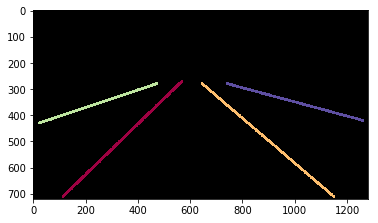

In [16]:
plt.imshow(coloring(gen_mask(ins_img)))

#### CLAHE

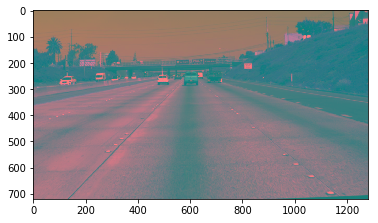

In [17]:
img = cv2.imread(os.path.join(train_path, raw_files[ind]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
plt.imshow(img)

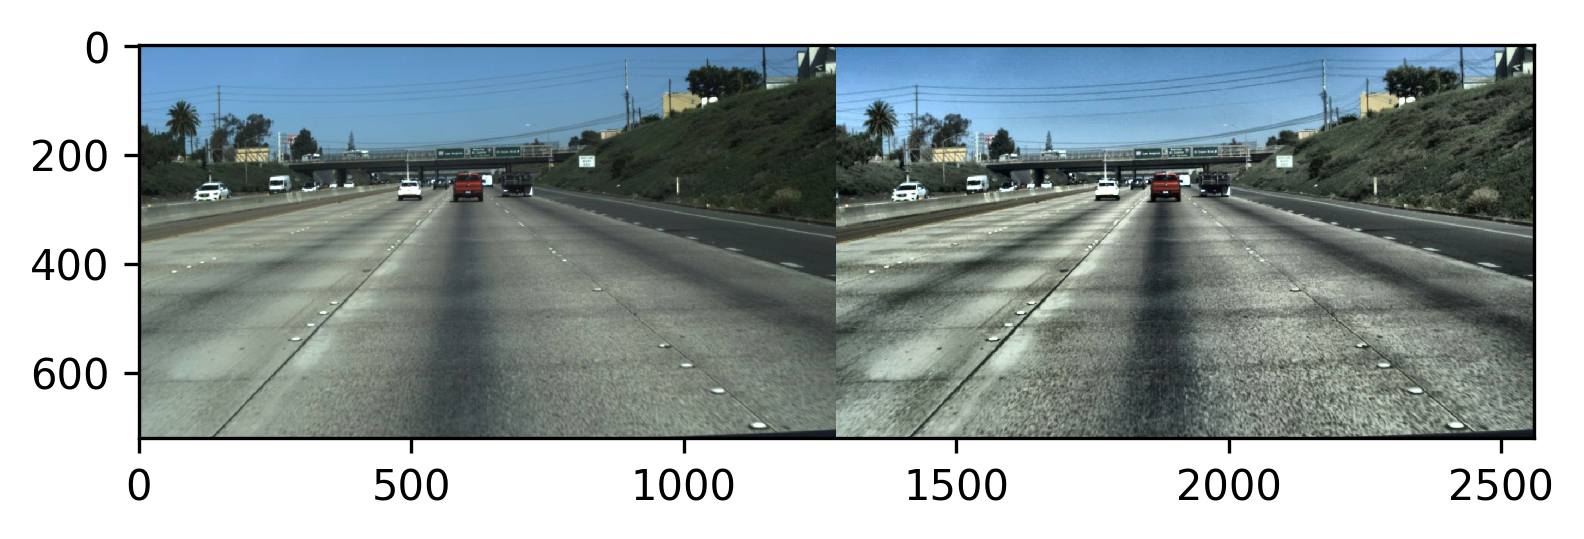

In [18]:
img_plane = cv2.split(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_plane[0] = clahe.apply(img_plane[0])
img1 = cv2.merge(img_plane)
img1 = np.hstack((img, img1))
img1 = cv2.cvtColor(img1, cv2.COLOR_LAB2RGB)

plt.figure(dpi=300)
plt.imshow(img1)

#### Pytorch Dataset

In [19]:
import torch
from torch.utils import data
from torchvision import transforms
from torchvision.utils import make_grid

In [20]:
from skimage.transform import AffineTransform, warp
from skimage import img_as_float64

In [21]:
class tuSimpleDataset(data.Dataset):
    # refer from : 
    # https://github.com/vxy10/ImageAugmentation
    # https://github.com/TuSimple/tusimple-benchmark/blob/master/example/lane_demo.ipynb
    def __init__(self, file_path, size=[640, 360], gray=True, train=True, intensity=10):
        self.width = size[0]
        self.height = size[1]
        self.file_path = file_path
        self.flags = {'size':size, 'gray':gray, 'train':train, 'intensity':intensity}
        self.json_lists = glob.glob(os.path.join(self.file_path, '*.json'))
        self.labels = []
        for json_list in self.json_lists:
            self.labels += [json.loads(line) for line in open(json_list)]
        self.lanes = [lane['lanes'] for lane in self.labels]
        self.y_samples = [y_sample['h_samples'] for y_sample in self.labels]
        self.raw_files = [raw_file['raw_file'] for raw_file in self.labels]
        self.img = np.zeros(size, np.uint8)
        self.label_img = np.zeros(size, np.uint8)
        self.ins_img = np.zeros((0,size[0],size[1]), np.uint8)
        
        self.len = len(self.labels)
        
    def warp_affine(self, M):
        self.img = cv2.warpAffine(self.img, M, tuple(self.flags['size']))
        self.label_img = cv2.warpAffine(self.label_img, M, tuple(self.flags['size']))
        
    def random_brightness(self):
        img = cv2.cvtColor(self.img, cv2.COLOR_RGB2HSV)
        rand_bright = .15 + np.random.uniform()
        img[:,:,2] = img[:,:,2]*rand_bright
        self.img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        
    def random_rotate(self, ang_range=20):
        ang_rot = np.random.uniform(ang_range) - ang_range/2
        Rot_M = cv2.getRotationMatrix2D((self.flags['size'][1]/2, self.flags['size'][0]/2), ang_rot, 1)
        self.warp_affine(Rot_M)
        
    def random_translate(self, trans_range=10):
        tr_x = trans_range * np.random.uniform() - trans_range/2
        tr_y = trans_range * np.random.uniform() - trans_range/2
        Trans_M = np.float32([[1, 0, tr_x],[0, 1, tr_y]])
        self.warp_affine(Trans_M)
        
    def random_shear(self, shear_range=5):
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        pt1 = 5+shear_range*np.random.uniform()-shear_range/2
        pt2 = 20+shear_range*np.random.uniform()-shear_range/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
        Shear_M = cv2.getAffineTransform(pts1, pts2)
        self.warp_affine(Shear_M)
        
    def random_transform(self):
        intensity=self.flags['intensity']
        def _get_delta(intensity):
            delta = np.radians(intensity)
            rand_delta = np.random.uniform(low=-delta, high=delta)
            return rand_delta

        trans_M = AffineTransform(scale=(.9, .9),
                                 translation=(-_get_delta(intensity), _get_delta(intensity)),
                                 shear=_get_delta(intensity))
        self.img = img_as_float64(self.img)
        self.img = warp(self.img, trans_M)
        self.label_img = img_as_float64(self.label_img)
        self.label_img = warp(self.label_img, trans_M)
        self.ins_img = img_as_float64(self.ins_img)
        for i in range(len(self.ins_img)):
            self.ins_img[i] = warp(self.ins_img[i], trans_M)

    def image_resize(self):
        ins = []
        self.img = cv2.resize(self.img, tuple(self.flags['size']), interpolation=cv2.INTER_CUBIC)
        self.label_img = cv2.resize(self.label_img, tuple(self.flags['size']), interpolation=cv2.INTER_CUBIC)
        for i in range(len(self.ins_img)):
            dst = cv2.resize(self.ins_img[i], tuple(self.flags['size']), interpolation=cv2.INTER_CUBIC)
            ins.append(dst)

        self.ins_img = np.array(ins, dtype=np.uint8)
    
    def preprocess(self):
        # CLAHE nomalization
        img = cv2.cvtColor(self.img, cv2.COLOR_RGB2LAB)
        img_plane = cv2.split(img)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_plane[0] = clahe.apply(img_plane[0])
        img = cv2.merge(img_plane)
        self.img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
   
    def get_lane_image(self, idx):
        lane_pts = [[(x,y) for (x,y) in zip(lane, self.y_samples[idx]) if x >= 0] for lane in self.lanes[idx]]
        self.img = plt.imread(os.path.join(self.file_path, self.raw_files[idx]))
        self.height, self.width, _ = self.img.shape
        self.label_img = np.zeros((self.height, self.width), dtype=np.uint8)
        self.ins_img = np.zeros((0, self.height, self.width), dtype=np.uint8)
        
        for i, lane_pt in enumerate(lane_pts):
            cv2.polylines(self.label_img, np.int32([lane_pt]), isClosed=False, color=(255), thickness=10)   
            gt = np.zeros((self.height, self.width), dtype=np.uint8)
            gt = cv2.polylines(gt, np.int32([lane_pt]), isClosed=False, color=(1), thickness=10)   
            self.ins_img = np.concatenate([self.ins_img, gt[np.newaxis]])

    def __getitem__(self, idx):
        self.get_lane_image(idx)
        self.image_resize()
        self.preprocess()

        if self.flags['train']:
            self.random_transform()
            self.img = np.array(np.transpose(self.img, (2,0,1)), dtype=np.float32)
            self.label_img = img_as_ubyte(self.label_img)
            self.ins_img = img_as_ubyte(self.ins_img)
            return torch.Tensor(self.img), torch.Tensor(self.label_img), torch.Tensor(self.ins_img)
        else:
            self.img = img_as_float64(self.img)
            self.img = np.array(np.transpose(self.img, (2,0,1)), dtype=np.float32)
            return torch.Tensor(self.img)
    
    def __len__(self):
        return self.len


In [22]:
D = tuSimpleDataset(train_path, size=[1280, 720])
dl = torch.utils.data.DataLoader(D)

rand_idx = random.randint(0, D.len)
transformed_img, transformed_label, ins = next(iter(dl))
print(np.shape(transformed_img), np.shape(transformed_label), np.shape(ins))

torch.Size([1, 3, 720, 1280]) torch.Size([1, 720, 1280]) torch.Size([1, 4, 720, 1280])


/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


In [23]:
img = np.transpose(transformed_img[0].cpu().data.numpy(), (1,2,0))
label = transformed_label[0].cpu().data.numpy()
ins2 = ins[0].cpu().data.numpy()

print(img.shape, label.shape, ins2.shape)

(720, 1280, 3) (720, 1280) (4, 720, 1280)


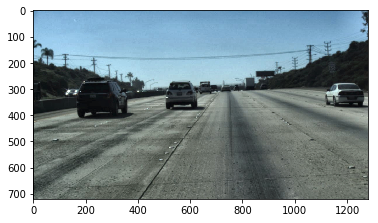

In [24]:
plt.imshow(img)

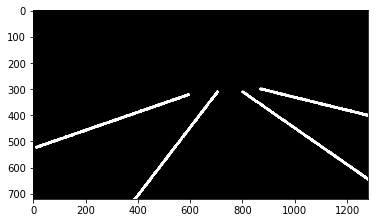

In [25]:
plt.imshow(label)

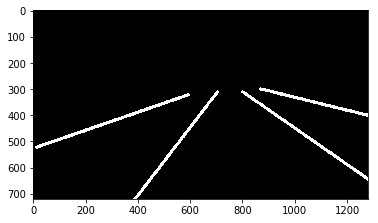

In [26]:
plt.imshow(ins2.sum(0))

In [27]:
assert(False)

AssertionError: 

### BDD-dataset

In [ ]:
train_path = '/data/bdd-data/bdd100k/images/100k/train/'
test_path = '/data/bdd-data/bdd100k/images/100k/test/'
val_path = '/data/bdd-data/bdd100k/images/100k/val/'

In [ ]:
train_label_path = '/data/bdd-data/bdd100k/labels/100k/train/'
val_label_path = '/data/bdd-data/bdd100k/labels/100k/val/'

In [ ]:
img_lists = sorted(glob.glob(train_path + '*.jpg'))

In [ ]:
img_lists[10]

In [ ]:
plt.imshow(plt.imread(img_lists[10]))

In [ ]:
json_train_lists = sorted(glob.glob(train_label_path + '*.json'))

In [ ]:
json_train_lists[10]

In [ ]:
labels = [json.load(open(json_train_list)) for json_train_list in json_train_lists]

In [ ]:
len(labels)

In [ ]:
objects = labels[10]['frames'][0]['objects']

In [ ]:
def get_lanes(objects):
    return [o for o in objects
           if 'poly2d' in o and o['category'][:4] == 'lane']

In [ ]:
lanes = get_lanes(objects)
lanes

In [ ]:
pts = []
for lane in lanes:
    pts.append([p[:2] for p in lane['poly2d']])

In [ ]:
pts

In [ ]:
img = plt.imread(img_lists[10])

In [ ]:
for i,pt in enumerate(pts):
    cv2.polylines(img, np.int32([pt]), isClosed=False, color=(0,255, 0),thickness=5)
plt.imshow(img)